In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/Admin/Desktop/project/cosmetics_full_data.csv")
df.head()

,Product_Name,Brand,Category,Usage_Frequency,Price_USD,Rating,Number_of_Reviews,Product_Size,Skin_Type,Gender_Target,Packaging_Type,Main_Ingredient,Cruelty_Free,Country_of_Origin
0,Ultra Face Mask,Drunk Elephant,Blush,Weekly,67.85,1.4,686,30ml,Sensitive,Female,Tube,Retinol,False,Australia
1,Ultra Lipstick,Laura Mercier,Makeup Remover,Occasional,116.43,4.2,5483,250ml,Dry,Unisex,Bottle,Shea Butter,False,UK
2,Ultra Serum,Natasha Denona,Highlighter,Daily,90.84,1.6,5039,100ml,Sensitive,Male,Compact,Aloe Vera,True,Italy
3,Divine Serum,Ilia Beauty,Face Mask,Occasional,55.17,3.2,6202,250ml,Normal,Male,Tube,Glycerin,True,South Korea
4,Super Foundation,Charlotte Tilbury,Highlighter,Occasional,140.56,1.7,297,100ml,Oily,Female,Compact,Glycerin,False,Germany


In [3]:
print("Before cleaning:",df.shape)

Before cleaning: (15000, 14)


In [4]:
df.ndim

2

In [5]:
df.dtypes

Product_Name          object
Brand                 object
Category              object
Usage_Frequency       object
Price_USD            float64
Rating               float64
Number_of_Reviews      int64
Product_Size          object
Skin_Type             object
Gender_Target         object
Packaging_Type        object
Main_Ingredient       object
Cruelty_Free            bool
Country_of_Origin     object
dtype: object

In [6]:
df.columns

Index(['Product_Name', 'Brand', 'Category', 'Usage_Frequency', 'Price_USD',
       'Rating', 'Number_of_Reviews', 'Product_Size', 'Skin_Type',
       'Gender_Target', 'Packaging_Type', 'Main_Ingredient', 'Cruelty_Free',
       'Country_of_Origin'],
      dtype='object')

In [7]:
df.isna().sum()

Product_Name         0
Brand                0
Category             0
Usage_Frequency      0
Price_USD            0
Rating               0
Number_of_Reviews    0
Product_Size         0
Skin_Type            0
Gender_Target        0
Packaging_Type       0
Main_Ingredient      0
Cruelty_Free         0
Country_of_Origin    0
dtype: int64

In [8]:
df = df.drop_duplicates()

In [9]:
def extract_number(x):
    if isinstance(x, str):
        num = ''.join([ch for ch in x if ch.isdigit() or ch == '.'])
        return float(num) if num != '' else np.nan
    return np.nan

df["Product_Size"] = df["Product_Size"].apply(extract_number)

In [ ]:
# Fill numerical missing 
num_cols = ["Price_USD", "Rating", "Number_of_Reviews", "Product_Size"]
for col in num_cols:
    df[col] = df[col].astype(float)
    df[col] = df[col].fillna(df[col].median())

In [11]:
cat_cols = ["Skin_Type", "Brand", "Category", "Main_Ingredient"]
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

In [12]:
print("After cleaning:", df.shape)

After cleaning: (15000, 14)


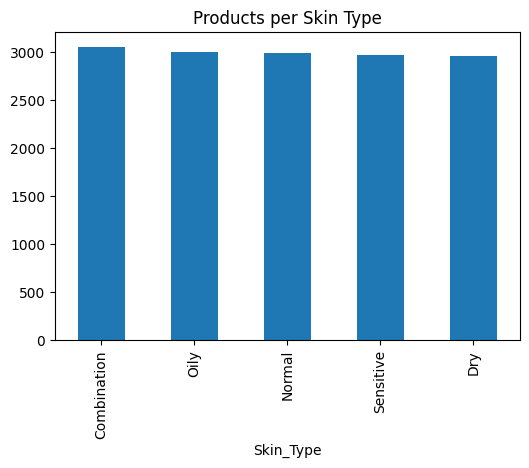

In [13]:
df["Skin_Type"].value_counts().plot(kind="bar", figsize=(6,4), title="Products per Skin Type")
plt.show()

In [14]:
def recommend_products(skin_type, top_n=10):
    skin_type = skin_type.lower()

    # Filter based on skin type (case-insensitive)
    filtered = df[df["Skin_Type"].str.lower().str.contains(skin_type)]

    # If no products match, fallback to similar category
    if len(filtered) == 0:
        print("No direct match found. Showing best overall products.")
        filtered = df.copy()

    # Sort by Final Score
    filtered = filtered.sort_values(by="Final_Score", ascending=False)

    return filtered.head(top_n)

In [15]:
df["Review_Score"] = np.log1p(df["Number_of_Reviews"])
df["Final_Score"] = (df["Rating"] * 0.6) + (df["Review_Score"] * 0.4)

df[["Rating", "Number_of_Reviews", "Final_Score"]].head()


,Rating,Number_of_Reviews,Final_Score
0,1.4,686.0,3.452934
1,4.2,5483.0,5.963836
2,1.6,5039.0,4.370065
3,3.2,6202.0,5.413115
4,1.7,297.0,3.298837


In [16]:
skin_type = "oily-skin"
recommended = recommend_products(skin_type, top_n=5)
recommended

No direct match found. Showing best overall products.


,Product_Name,Brand,Category,Usage_Frequency,Price_USD,Rating,Number_of_Reviews,Product_Size,Skin_Type,Gender_Target,Packaging_Type,Main_Ingredient,Cruelty_Free,Country_of_Origin,Review_Score,Final_Score
14812,Ultra Eye Shadow,Sisley,Moisturizer,Occasional,77.73,5.0,9991.0,250.0,Combination,Female,Stick,Aloe Vera,False,France,9.209540,6.683816
3482,Ultra Lip Gloss,Perricone MD,Lipstick,Weekly,107.54,5.0,9915.0,150.0,Dry,Unisex,Spray,Salicylic Acid,True,France,9.201905,6.680762
242,Divine Bronzer,Farsali,Foundation,Occasional,103.00,5.0,9904.0,30.0,Dry,Unisex,Stick,Vitamin C,True,Australia,9.200795,6.680318
6527,Divine Blush,Kylie Cosmetics,Moisturizer,Occasional,106.31,5.0,9858.0,100.0,Sensitive,Unisex,Stick,Shea Butter,False,UK,9.196140,6.678456
9793,Super Eye Shadow,Huda Beauty,BB Cream,Occasional,142.16,5.0,9702.0,100.0,Normal,Male,Bottle,Retinol,False,Japan,9.180190,6.672076


In [17]:
# CRUELTY-FREE SCORE (boost products safe for skin)
df["Cruelty_Score"] = df["Cruelty_Free"].apply(lambda x: 1 if str(x).lower()=="yes" else 0)

In [18]:
# Normalize price (lower is better)
df["Price_Score"] = (df["Price_USD"].max() - df["Price_USD"]) / df["Price_USD"].max()

In [19]:
# INGREDIENT SIMILARITY USING TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

df["Main_Ingredient"] = df["Main_Ingredient"].fillna("")

tfidf = TfidfVectorizer(stop_words="english")
ingredient_matrix = tfidf.fit_transform(df["Main_Ingredient"])


In [20]:
# SKIN TYPE MATCH SCORE
def skin_match(product_skin, user_skin):
    if str(product_skin).lower() in str(user_skin).lower():
        return 1
    return 0

In [ ]:
import numpy as np

df["Review_Score"] = np.log1p(df["Number_of_Reviews"])
df["Popularity_Score"] = (
    (df["Rating"] * 0.5) +
    (df["Review_Score"] * 0.3) +
    (df["Cruelty_Score"] * 0.1)
)


In [28]:
# HYBRID RECOMMENDER (UPDATED)
from sklearn.metrics.pairwise import cosine_similarity

def recommend_products_optimized(skin_type, top_n=10):
    user_skin = skin_type.lower()

    # --- 1. STRICT FILTER (only same skin type)
    df_skin = df[df["Skin_Type"].str.lower().str.contains(user_skin)]

    # If no products match, fallback to whole dataset
    if len(df_skin) == 0:
        df_skin = df.copy()

    # --- 2. Compute Skin Match Score
    df_skin["Skin_Match_Score"] = df_skin["Skin_Type"].apply(
        lambda x: skin_match(x, user_skin)
    )

    # --- 3. Ingredient Similarity
    skin_products = df[df["Skin_Type"].str.lower().str.contains(user_skin)]

    if len(skin_products) > 0:
        avg_vec = ingredient_matrix[skin_products.index].mean(axis=0)
        similarity_scores = cosine_similarity(
            ingredient_matrix[df_skin.index], 
            avg_vec.reshape(1, -1)
        )
        df_skin["Ingredient_Similarity"] = similarity_scores.flatten()
    else:
        df_skin["Ingredient_Similarity"] = 0

    # --- 4. Final Hybrid Score (improved weights)
    df_skin["Final_Score"] = (
        (df_skin["Popularity_Score"] * 0.3) +          # 30%
        (df_skin["Ingredient_Similarity"] * 0.3) +     # 30%
        (df_skin["Skin_Match_Score"] * 0.4)            # 40%
    )

    # --- 5. Sort and return top N
    results = df_skin.sort_values(by="Final_Score", ascending=False)

    return results.head(top_n)


In [29]:
recommend_products_optimized("oily-skin", top_n=10)


,Product_Name,Brand,Category,Usage_Frequency,Price_USD,Rating,Number_of_Reviews,Product_Size,Skin_Type,Gender_Target,...,Main_Ingredient,Cruelty_Free,Country_of_Origin,Review_Score,Final_Score,Cruelty_Score,Price_Score,Popularity_Score,Skin_Match_Score,Ingredient_Similarity
3466,Perfect Powder,Bite Beauty,Serum,Occasional,125.24,5.0,9292.0,30.0,Oily,Male,...,Shea Butter,True,UK,9.137017,1.972332,0,0.165011,5.241105,1,0
7146,Magic Lip Gloss,Shiseido,Eye Shadow,Occasional,62.94,5.0,9181.0,200.0,Oily,Female,...,Retinol,False,Italy,9.125000,1.971250,0,0.580372,5.237500,1,0
8836,Super Highlighter,Yves Saint Laurent,Makeup Remover,Occasional,141.56,5.0,8957.0,250.0,Oily,Unisex,...,Aloe Vera,False,South Korea,9.100302,1.969027,0,0.056204,5.230091,1,0
10400,Magic Eye Shadow,Bobby Brown,Cleanser,Daily,42.91,5.0,8693.0,250.0,Oily,Male,...,Retinol,True,Germany,9.070388,1.966335,0,0.713914,5.221117,1,0
5146,Divine Makeup Remover,Kylie Cosmetics,Serum,Occasional,87.64,4.9,9865.0,250.0,Oily,Female,...,Vitamin C,True,Germany,9.196850,1.962716,0,0.415694,5.209055,1,0
14413,Perfect Exfoliator,ColourPop,Lip Gloss,Daily,103.98,4.9,9855.0,150.0,Oily,Male,...,Aloe Vera,False,USA,9.195836,1.962625,0,0.306754,5.208751,1,0
101,Magic Highlighter,IT Cosmetics,Lip Liner,Occasional,141.34,4.9,9617.0,200.0,Oily,Female,...,Aloe Vera,True,Japan,9.171392,1.960425,0,0.057671,5.201417,1,0
8138,Perfect Serum,IT Cosmetics,Serum,Daily,26.94,4.9,9539.0,150.0,Oily,Unisex,...,Glycerin,False,USA,9.163249,1.959692,0,0.820388,5.198975,1,0
1090,Super Eye Shadow,Bite Beauty,Setting Spray,Occasional,61.95,4.9,9465.0,100.0,Oily,Unisex,...,Hyaluronic Acid,True,Japan,9.155462,1.958992,0,0.586972,5.196639,1,0
14115,Divine Setting Spray,Patrick Ta,Setting Spray,Weekly,90.87,4.9,9364.0,150.0,Oily,Female,...,Hyaluronic Acid,False,Japan,9.144735,1.958026,0,0.394160,5.193420,1,0
